In [1]:
LR = 0.005
EPOCHS = 2
BATCHSIZE = 32
CHANNELS = 64
IMAGE_SIZE = 512
NBLOCK = 6 
DEPTH = 2
MOMENTUM = 0.9




from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
tf.enable_eager_execution()
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras import Model, Sequential
from tensorflow.keras import layers 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.metrics as metrics
from tensorflow import keras


D:\Anaconda3\envs\df_env\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\envs\df_env\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\envs\df_env\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\envs\df_env\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
plt.rcParams["figure.figsize"] = (10, 10)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rc('lines', linewidth=3)
plt.rc('font', size=15)


In [3]:
import random

random.seed(10)
np.random.seed(10)
tf.random.set_random_seed(10)


In [4]:
import os
os.chdir(r"E:\archive")

In [5]:
directory_test = 'chest_xray/chest_xray/test/NORMAL/'
directory_train = 'chest_xray/chest_xray/train/NORMAL/'
directory_val = 'chest_xray/chest_xray/val/NORMAL/'
directory_train_nih = 'chest_xray/NIH NORMAL/'
image_paths_norm = sorted(list(paths.list_images(directory_test))) + \
                   sorted(list(paths.list_images(directory_train))) + \
                   sorted(list(paths.list_images(directory_val))) +\
                    sorted(list(paths.list_images(directory_train_nih))) 

labels_norm = ['Normal'] * len(image_paths_norm)


In [6]:
directory_test_pn = 'chest_xray/chest_xray/test/PNEUMONIA/'
directory_train_pn = 'chest_xray/chest_xray/train/PNEUMONIA/'
directory_val_pn = 'chest_xray/chest_xray/val/PNEUMONIA/'
image_paths_pn = sorted(list(paths.list_images(directory_test_pn))) + \
                 sorted(list(paths.list_images(directory_train_pn))) + \
                 sorted(list(paths.list_images(directory_val_pn)))

labels_pn = ['Pneumonia'] * len(image_paths_pn)

image_paths = np.array(image_paths_norm + image_paths_pn)
labels = np.concatenate((labels_norm, labels_pn))

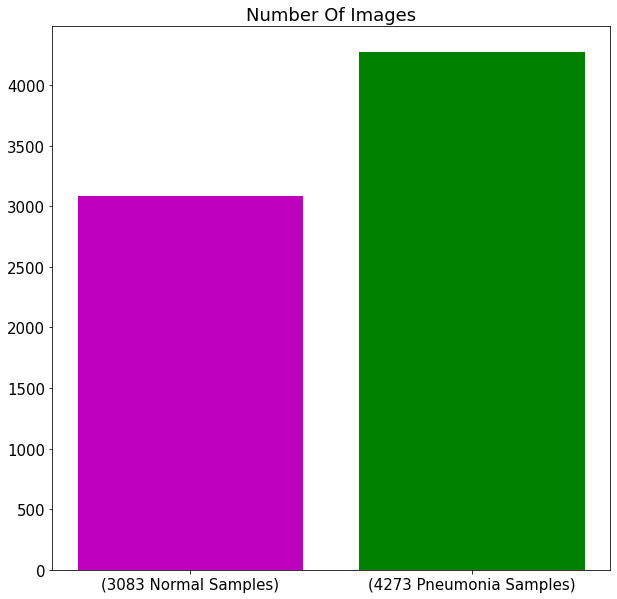

In [7]:
plt.bar([1, 2], height=[len(labels_norm), len(labels_pn)], 
        tick_label=['({0:d} Normal Samples)'.format(len(labels_norm)), 
                    '({0:d} Pneumonia Samples)'.format(len(labels_pn))], 
        color=['m', 'g'])

plt.title('Number Of Images'.
          format(len(labels_norm) + len(labels_pn)))

plt.show()


In [8]:
from sklearn.model_selection import train_test_split

X_train_dir, X_test_dir, y_train, y_test = \
                                           train_test_split(image_paths, labels, test_size=0.3)

X_val_dir, y_val = X_test_dir[:len(X_test_dir) // 2], \
                   y_test[:len(y_test) // 2]

X_test_dir, y_test = X_test_dir[len(X_test_dir) // 2:], \
                     y_test[len(y_test) // 2:]



In [9]:
train_df = pd.DataFrame(np.transpose([X_train_dir, y_train]), 
                        columns=['filename', 'class'])

val_df = pd.DataFrame(np.transpose([X_val_dir, y_val]), 
                      columns=['filename', 'class'])

test_df = pd.DataFrame(np.transpose([X_test_dir, y_test]), 
                       columns=['filename', 'class'])


In [10]:
BATCH_SIZE = 16

datagen = ImageDataGenerator(rescale = 1./255,
                             zoom_range=0.1, 
                             height_shift_range=0.05, 
                             width_shift_range=0.05,
                             rotation_range=5)


test_datagen = ImageDataGenerator(rescale = 1./255)

train_gen = datagen.flow_from_dataframe(train_df,
                                        target_size=(512, 512),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        shuffle=True)

val_gen = test_datagen.flow_from_dataframe(val_df,
                                        target_size=(512, 512),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        shuffle=False)

test_gen = test_datagen.flow_from_dataframe(test_df,
                                        target_size=(512, 512),
                                        color_mode='grayscale',
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        shuffle=False)


Found 5149 validated image filenames belonging to 2 classes.
Found 1103 validated image filenames belonging to 2 classes.
Found 1104 validated image filenames belonging to 2 classes.


In [11]:
train_data = tf.data.Dataset.from_generator(lambda: train_gen,
                                            output_types=(tf.float32, tf.int32),
                                            output_shapes=([None, 512, 512, 1], [None, ]))

val_data = tf.data.Dataset.from_generator(lambda: val_gen,
                                          output_types=(tf.float32, tf.int32),
                                          output_shapes=([None, 512, 512, 1], [None, ]))

test_data = tf.data.Dataset.from_generator(lambda: test_gen,
                                           output_types=(tf.float32, tf.int32),
                                           output_shapes=([None, 512, 512, 1], [None, ]))


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [12]:
images_to_augment = []

for image_path in image_paths[:4]:
    image = load_img(image_path, target_size=(512, 512))
    image = img_to_array(image)
    images_to_augment.append(image)
    
images_to_augment = np.array(images_to_augment)

images_augmented = next(datagen.flow(x=images_to_augment,
                                batch_size=10,
                                shuffle=False))


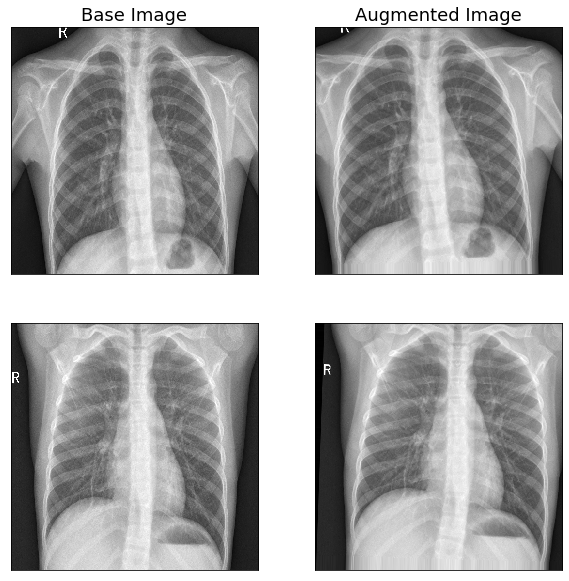

In [13]:
from tensorflow.keras.preprocessing.image import array_to_img

fig, axes = plt.subplots(2, 2)

for i in range(2):
    axes[i, 0].imshow(array_to_img(images_to_augment[i]), 
                      interpolation='nearest')
    
    axes[i, 1].imshow(array_to_img(images_augmented[i]), 
                      interpolation='nearest')
    
    axes[i, 0].set_xticks([])
    axes[i, 1].set_xticks([])
    
    axes[i, 0].set_yticks([])
    axes[i, 1].set_yticks([])
    
columns = ['Base Image', 'Augmented Image']
for ax, column in zip(axes[0], columns):
    ax.set_title(column) 
    
plt.show()


In [14]:
def feed_data(dataset):

    
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)  
    
    return dataset


In [15]:
def convlayer(channels, inputs, size=3, padding='same'):
    x = keras.layers.BatchNormalization(momentum=MOMENTUM)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, size, padding=padding, use_bias=False)(x)
    return x

def just_downsample(inputs, pool=2):
    x = keras.layers.BatchNormalization(momentum=MOMENTUM)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.MaxPool2D(pool)(x)
    return x

def convblock(inputs, channels1, channels2):
    x = convlayer(channels1, inputs)
    x = convlayer(channels2, x)
    x = keras.layers.Concatenate()([inputs, x])
    return x

def denseblock(inputs, nblocks=6, channels1=128, channels2=32):
    x = inputs
    for i in range(nblocks):
        x = convblock(x, channels1, channels2)
    x = keras.layers.SpatialDropout2D(.2)(x)
    return x

def transition(inputs, channels, pool=2):
    x = convlayer(channels, inputs)
    x = keras.layers.AveragePooling2D(pool)(x)
    return x
    
def create_network(input_size, channels=64, channels2=32, n_blocks=NBLOCK, depth=DEPTH):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', strides=2, use_bias=False)(inputs)
    x = just_downsample(x)

    # densenet blocks
    nchan = channels
    for d in range(depth-1):
        x = denseblock(x)
        nchan = ( nchan + n_blocks*channels2 ) // 2
        x = transition(x, nchan)
    x = denseblock(x)

    # output
    x = convlayer(channels, x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Dropout(.5)(x)
    output = keras.layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs=inputs, outputs=output)
    return model


In [16]:
model = create_network(input_size=IMAGE_SIZE, channels=CHANNELS, n_blocks=NBLOCK, depth=DEPTH)
model.compile(optimizer=keras.optimizers.Adam(lr=LR),
              loss=keras.losses.binary_crossentropy, metrics=['accuracy'])


In [17]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 576         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [18]:
def lr_decay(epoch):
    
    initial_lr = 0.001    
    lr = initial_lr * np.exp(-0.1 * epoch)
    return lr


In [19]:
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler

lr_scheduler = LearningRateScheduler(lr_decay, 1)
csv_logger = CSVLogger(filename='NIH+PNEUMONIA_7layers.csv')
model_checkpoint = ModelCheckpoint(filepath='NIH+PNEUMONIA_7layers{epoch:04d}.hdf5')


In [20]:
train_steps = train_gen.samples // BATCH_SIZE
val_steps = val_gen.samples // BATCH_SIZE


In [21]:

history = model.fit(feed_data(train_data),                    
                    epochs=5,                    
                    steps_per_epoch=train_steps,                    
                    validation_data=(feed_data(val_data)),
                    validation_steps=val_steps,                    
                    shuffle=False,
                    callbacks=[lr_scheduler, csv_logger, model_checkpoint])



Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
321/321 [==============================] - 377s 1s/step - loss: 0.3560 - acc: 0.8524 - val_loss: 1.3911 - val_acc: 0.5616

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0009048374180359595.
Epoch 2/5
321/321 [==============================] - 327s 1s/step - loss: 0.2949 - acc: 0.8802 - val_loss: 0.4892 - val_acc: 0.8079

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0008187307530779819.
Epoch 3/5
321/321 [==============================] - 319s 994ms/step - loss: 0.2751 - acc: 0.8907 - val_loss: 0.2264 - val_acc: 0.9145

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0007408182206817179.
Epoch 4/5
321/321 [==============================] - 319s 995ms/step - loss: 0.2547 - acc: 0.9010 - val_loss: 0.2476 - val_acc: 0.9274

Epoch 00005: LearningRateScheduler reducing lea

In [22]:
import pandas as pd
seven_layer_aug = pd.read_csv("NIH+PNEUMONIA_7layers.csv")


In [23]:
def plot_loss(results, title, ylim=None, figsize=(15, 15)):

    
    plt.figure(figsize=figsize)

    for name, result in results:
        val = plt.plot(range(len((result['epoch']))), result['val_loss'],
                       '--', label=name.title()+', Validation', lw=3.0)
        plt.plot(range(len((result['epoch']))), result['loss'], color=val[0].get_color(),
                 label=name.title()+', Training', lw=3.0)

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.ylim(ylim)
    plt.grid(lw=2, ls='--')


In [24]:
def plot_accuracy(results, title, x_range=20, figsize=(15, 15)):

    
    plt.figure(figsize=figsize)

    for name, result in results:
        val = plt.plot(range(len((result['epoch']))), result['val_accuracy'],
                       '--', label=name.title()+', Validation', lw=3.0)
        plt.plot(range(len((result['epoch']))), result['accuracy'], color=val[0].get_color(),
                 label=name.title()+', Training', lw=3.0)

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(lw=2, ls='--')


In [25]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


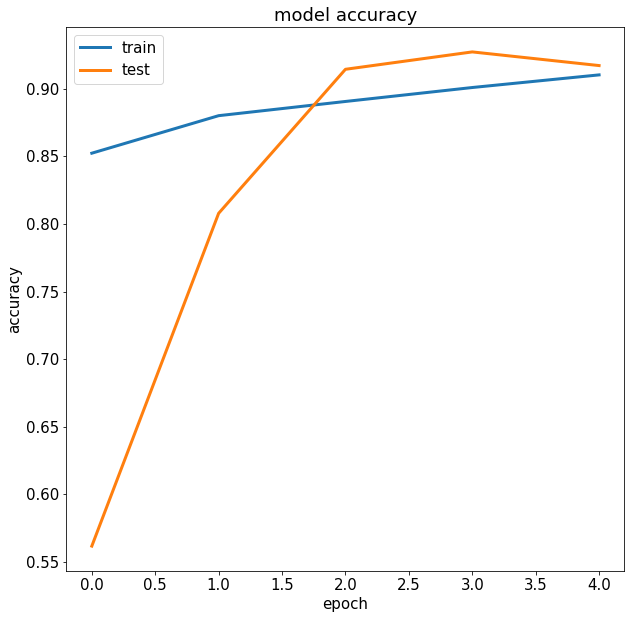

In [26]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
test_steps = test_gen.samples // BATCH_SIZE
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
model.evaluate(test_data, steps=test_steps)


predictions = model.predict(test_data, steps=test_steps).flatten()
y_true = test_gen.classes[:len(predictions)]

precision.update_state(y_true, predictions)
recall.update_state(y_true, predictions)


69/69 [==============================] - 24s 350ms/step - loss: 0.2175 - acc: 0.9185


In [29]:
print('Precision test data:', precision.result().numpy())
print('Recall test data:', recall.result().numpy())


Precision test data: 0.9490446
Recall test data: 0.91131496
